In [67]:
import numpy as np
from random import random as rand
from math import floor
from numba import cuda

import matplotlib.pyplot as plt

# Optimization SN P Systems

In [91]:
H = 64
m = 64
runs = 1000

In [92]:
# Defining 2 fitness functions:
# 1 is basic sum of components
# 2 is knapsack problem

def fitness(arr):
    return np.sum(arr)

omega = m*3
K = m
w = np.random.randint(1, omega, K)
p = w + 0.5*omega
C = 0.5*np.sum(w)

def fitness_knapsack(arr):
    knapsack = np.sum(np.multiply(arr, p))
    load = np.sum(np.multiply(arr, w))
    return knapsack if load <= C else -1

In [74]:
# prob matrix P => chromosome matrix T
# serial version

def spike(P):
    T = np.zeros((H, m))
    for i in range(H):
        for j in range(m):
            if (rand() < P[i,j]):
                T[i,j] = 1
                
    return T

In [105]:
# prob matrix P => chromosome matrix T
# serial version

@cuda.jit
def parallel_spike(T,P,R1):
    # T = np.zeros((H, m))
#     for i in range(H):
#         for j in range(m):
#             if (R1[i,j] < P[i,j]):
#                 T[i,j] = 1
    tx = cuda.threadIdx.x
    ty = cuda.blockIdx.x
    
    block_size = cuda.blockDim.x  
    grid_size = cuda.gridDim.x    
    
    start = tx + ty * block_size
    stride = block_size * grid_size
    
#     for i in range(start, P.shape[0], stride):
#         for j in range(start,P.shape[0],stride):
    T[tx,ty] = 1 if R1[tx,ty] < P[tx,ty] else 0

In [100]:
# generate fitness vector of chromosomes
# return the most fit chromie

def fitness_vector(T):
    F = [fitness_knapsack(T[i]) for i in range(H)]
    return F

def fitness_argmax(F):
    arg = 0
    for i in range(1, H):
        arg = i if F[i] > F[arg] else arg
    return arg

In [101]:
# chromosome matrix T, prob matrix P, fitness vector F => new prob matrix P
# serial version

def guide(T, P, F, F_argmax):
    for i in range(H):
        for j in range(m):
            if (rand() < a[j]):
                k1, k2 = i, i
                while (k1 == i or k2 == i):
                    k1, k2 = [floor(rand() * H) for i in range(2)]
                b = T[k1,j] if F[k1] > F[k2] else T[k2,j]
                P[i,j] = P[i,j] + delta if b > 0.5 else P[i,j] - delta
            else:
                P[i,j] = P[i,j] + delta if T[F_argmax,j] > 0.5 else P[i,j] - delta
            
            # Adjustments
            if P[i,j] > 1:
                P[i,j] -= delta
            if P[i,j] < 0:
                P[i,j] += delta
    return P

In [138]:
@cuda.jit
def parallel_guide(T, P, F, F_argmax,a,delta,R2,R3,R4):
    
    tx = cuda.threadIdx.x
    ty = cuda.blockIdx.x
    
    block_size = cuda.blockDim.x  
    grid_size = cuda.gridDim.x    
    
    
#     for i in range(H):
#         for j in range(m):
#             if (rand() < a[j]):
#                 k1, k2 = i, i
#                 while (k1 == i or k2 == i):
#                     k1, k2 = [floor(rand() * H) for i in range(2)]
#                 b = T[k1,j] if F[k1] > F[k2] else T[k2,j]
#                 P[i,j] = P[i,j] + delta if b > 0.5 else P[i,j] - delta
#             else:
#                 P[i,j] = P[i,j] + delta if T[F_argmax,j] > 0.5 else P[i,j] - delta
            
#             # Adjustments
#             if P[i,j] > 1:
#                 P[i,j] -= delta
#             if P[i,j] < 0:
#                 P[i,j] += delta
    if(R2[tx,ty] < a[ty]):
        k1 = tx
        k2 = ty
        while (k1 == tx or k2 == tx):
            k1 = floor(R3[tx,ty]*H)
            k2 = floor(R4[tx,ty]*H)
        b = T[k1,ty] if F[k1] > F[k2] else T[k2,ty]
        P[tx,ty] = P[tx,ty] + delta if b > 0.5 else P[tx,ty] - delta
    else:
        P[tx,ty] = P[tx,ty] + delta if T[F_argmax,ty] > 0.5 else P[tx,ty] - delta
        
    if P[tx,ty] > 1:
        P[tx,ty] -= delta
    if P[tx,ty] < 0:
        P[tx,ty] += delta

In [139]:
# Define the initial probability array and learning rate
P = np.random.random_sample((H, m))
a = 0.15 * np.random.random_sample(m) + 0.05
delta = 0.015 * rand() + 0.005

In [140]:
threads_per_block = 64
blocks_per_grid = 64

T = np.zeros((H,m))


# parallel_spike[blocks_per_grid, threads_per_block](T, P, R1)
# print(T)

In [141]:
# game loop
# initial fitness

T = spike(P)
F = fitness_vector(T)

ave_fitness = []
ave_fitness.append(np.mean(F))

In [142]:
for r in range(runs):
    guide(T, P, F, fitness_argmax(F))
    T = spike(P)
    F = fitness_vector(T)
    ave_fitness.append(np.mean(F))

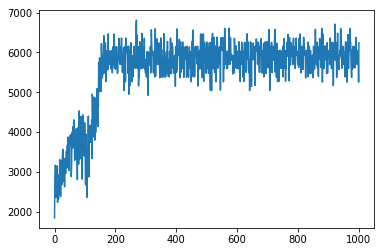

In [143]:
plt.plot(np.arange(runs+1), ave_fitness)

In [144]:
# game loop
# initial fitness

# delete when sane
P = np.random.random_sample((H, m))
a = 0.15 * np.random.random_sample(m) + 0.05
delta = 0.015 * rand() + 0.005

parallel_spike[blocks_per_grid, threads_per_block](T,P,R1)
F = fitness_vector(T)

ave_fitness = []
ave_fitness.append(np.mean(F))

In [145]:
for r in range(runs):
    R1 = np.random.random_sample((H, m))
    R2 = np.random.random_sample((H, m))
    R3 = np.random.random_sample((H, m))
    R4 = np.random.random_sample((H, m))
    parallel_guide[blocks_per_grid, threads_per_block](T, P, F, fitness_argmax(F),a,delta,R2,R3,R4)
    parallel_spike[blocks_per_grid, threads_per_block](T,P,R1)
    F = fitness_vector(T)
    ave_fitness.append(np.mean(F))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mInvalid use of Function(<built-in function getitem>) with argument(s) of type(s): (reflected list(int64), float64)
 * parameterized
[1mIn definition 0:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 1:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 2:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 3:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 4:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 5:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 6:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 7:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 8:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 9:[0m
[1m    All templates rejected without literals.[0m
[1mThis error is usually caused by passing an argument of a type that is unsupported by the named function.[0m[0m
[0m[1m[1] During: typing of intrinsic-call at <ipython-input-138-eb1cc1a4219f> (33)[0m
[1m
File "<ipython-input-138-eb1cc1a4219f>", line 33:[0m
[1mdef parallel_guide(T, P, F, F_argmax,a,delta,R2,R3,R4):
    <source elided>
            k2 = floor(R4[tx,ty]*H)
[1m        b = T[k1,ty] if F[k1] > F[k2] else T[k2,ty]
[0m        [1m^[0m[0m


In [ ]:
plt.plot(np.arange(runs+1), ave_fitness)